---
# Portfolio Backtest with Backtrader
---

In [189]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.dates import (HOURS_PER_DAY, MIN_PER_HOUR, SEC_PER_MIN,
                              MONTHS_PER_YEAR, DAYS_PER_WEEK,
                              SEC_PER_HOUR, SEC_PER_DAY,
                              num2date, rrulewrapper, YearLocator,
                              MicrosecondLocator)

%matplotlib inline

In [190]:
# Pandas_datareader override
yf.pdr_override()
pd.options.display.float_format = '{:.4f}'.format

In [217]:
# Date range
start = '2016-01-01'
end = '2021-08-16'

## Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD','SPY']
assets.sort()

prices = yf.download(assets, start=start, end=end)
prices = prices.dropna()
prices.tail()

[*********************100%***********************]  5 of 5 completed


Adj Close                                                   \
                   AGG        ARKK       BRK-B      ETH-USD         SPY   
Date                                                                      
2021-08-09 11558.0002% 12469.9997% 28723.0011% 316785.6201% 44213.0005%   
2021-08-10 11543.0000% 12144.0002% 28894.0002% 314169.1162% 44267.9993%   
2021-08-11 11554.0001% 12130.0003% 29127.9999% 316424.5117% 44377.9999%   
2021-08-12 11555.0003% 12184.9998% 29023.9990% 304341.4307% 44510.9985%   
2021-08-13 11597.0001% 12009.9998% 28789.0015% 332221.1670% 44592.0013%   

                 Close                                                   ...  \
                   AGG        ARKK       BRK-B      ETH-USD         SPY  ...   
Date                                                                     ...   
2021-08-09 11558.0002% 12469.9997% 28723.0011% 316785.6201% 44213.0005%  ...   
2021-08-10 11543.0000% 12144.0002% 28894.0002% 314169.1162% 44267.9993%  ...   
2021-08-11 11554.0001% 12130.0003% 29127.9999% 316424.5117% 44377.9999%  ...   
2021-08-12 11555.0003% 12184.9998% 29023.9990% 304341.4307% 44510.9985%  ...   
2021-08-13 11597.0001% 12009.9998% 28789.0015% 332221.1670% 44592.0013%  ...   

                  Open                                                   \
                   AGG        ARKK       BRK-B      ETH-USD         SPY   
Date                                                                      
2021-08-09 11588.9999% 12362.9997% 28785.9985% 301288.5742% 44245.9991%   
2021-08-10 11565.0002% 12487.0003% 28701.0010% 316305.0049% 44260.9985%   
2021-08-11 11545.9999% 12255.9998% 28945.0012% 314283.0322% 44382.0007%   
2021-08-12 11548.9998% 12090.0002% 29180.9998% 316417.5781% 44361.9995%   
2021-08-13 11565.0002% 12195.9999% 29060.9985% 304900.1221% 44558.9996%   

                    Volume                                  \
                       AGG            ARKK           BRK-B   
Date                                                         
2021-08-09 529860000.0000% 452810000.0000% 367650000.0000%   
2021-08-10 733210000.0000% 538710000.0000% 313410000.0000%   
2021-08-11 667460000.0000% 600790000.0000% 347510000.0000%   
2021-08-12 501730000.0000% 332030000.0000% 317030000.0000%   
2021-08-13 459980000.0000% 396880000.0000% 311520000.0000%   

                                                 
                       ETH-USD              SPY  
Date                                             
2021-08-09 3198326093600.0000% 4122260000.0000%  
2021-08-10 2760522171000.0000% 4333930000.0000%  
2021-08-11 2672903505200.0000% 4403430000.0000%  
2021-08-12 2540369984500.0000% 3890940000.0000%  
2021-08-13 2386886625400.0000% 3938830000.0000%  

[5 rows x 30 columns]

---
# Backtest Function
---

In [218]:
# Defining the backtest function 
def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [219]:
# Create objects that contain the prices of assets

# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))
        

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

prices_.head()

,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,20102.0004%,20102.9999%,19858.9996%,20049.0005%,22235350000.0000%
2016-01-05,20136.0001%,20189.9994%,20005.0003%,20139.9994%,11084580000.0000%
2016-01-06,19882.0007%,20005.9998%,19760.0006%,19833.9996%,15211260000.0000%
2016-01-07,19405.0003%,19744.0002%,19358.9996%,19533.0002%,21343610000.0000%
2016-01-08,19191.9998%,19585.0006%,19158.0002%,19519.0002%,20981720000.0000%


---
# Buy and Hold Strategy
---

In [220]:
class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

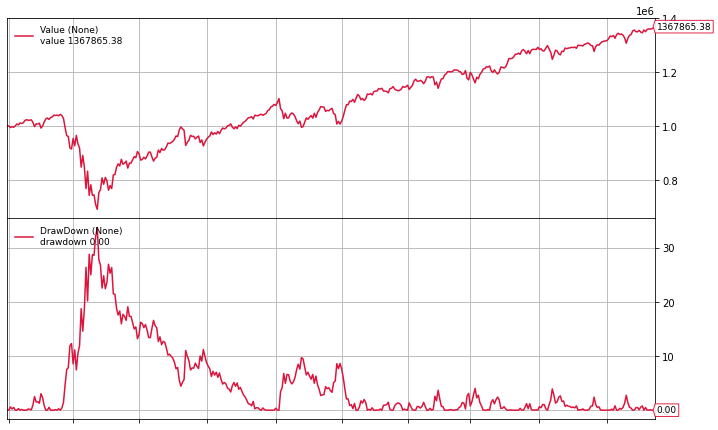

In [221]:
# Run the backtest for the selected period
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

start = 1004
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [222]:
# Buy and Hold Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.2f}")

Max Drawdown: 33.72%
CAGR: 5.80%
Sharpe: 0.70


----
# Quarterly Rebalancing
----

In [223]:
# Calculate assets returns
pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=['SPY']).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,AGG,ARKK,BRK-B,ETH-USD
Date,,,,
2016-01-05,0.0463%,0.7996%,0.3824%,-0.4509%
2016-01-06,0.3796%,-1.6857%,0.0610%,0.0720%
2016-01-07,-0.0092%,-3.9334%,-1.4087%,-0.9313%
2016-01-08,0.2213%,-1.1548%,-0.8882%,4.7541%
2016-01-11,-0.2853%,-3.5051%,0.0234%,7.5813%


In [224]:
# Selecting Dates for Rebalancing
# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

----
# Portfolio Constraints
----

In [226]:
# Create constraints (you can create more detailed constraints - see example codes)
asset_classes = {'Assets': ['AGG', 'ARKK', 'BRK-B', 'ETH-USD'],
                 'Class 1': ['Fixed Income', 'Equity', 'Equity', 'Crypto'],
                }
asset_classes = pd.DataFrame(asset_classes)
constraints = pd.read_excel('/Users/draganbogatic/Documents/Fin_Tech/portfolio_optimization/resources/constraints.xls',  index_col='Index')
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
Index,,,,,,,,,,
0,False,Classes,Class 1,Equity,>=,60.0000%,nan%,nan%,nan%,nan%
1,False,Classes,Class 1,Fixed Income,<=,30.0000%,nan%,nan%,nan%,nan%
2,False,Classes,Class 1,Crypto,<=,3.0000%,nan%,nan%,nan%,nan%
3,False,Assets,NaN,BRK-B,>=,30.0000%,nan%,nan%,nan%,nan%
4,False,Assets,NaN,BRK-B,<=,50.0000%,nan%,nan%,nan%,nan%


In [227]:
# Building constraint matrixes for Riskfolio Lib
import riskfolio.ConstraintsFunctions as cf

A, B = cf.assets_constraints(constraints, asset_classes)

---
# Portfolio Optimization
---

In [228]:
%%time
# Building a loop that estimate optimal portfolios on
# rebalancing dates
import riskfolio.Portfolio as pf

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV', 'CVaR', 'WR', 'CDaR']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns.iloc[i-1000:i,:] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = pf.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
        
        # Estimate optimal portfolio:
        
        #port.solvers = ['MOSEK']
        port.alpha = 0.05
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

CPU times: user 7.06 s, sys: 1.66 s, total: 8.72 s
Wall time: 1.53 s


In [229]:
class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

---
# Mean-Variance Strategy
---

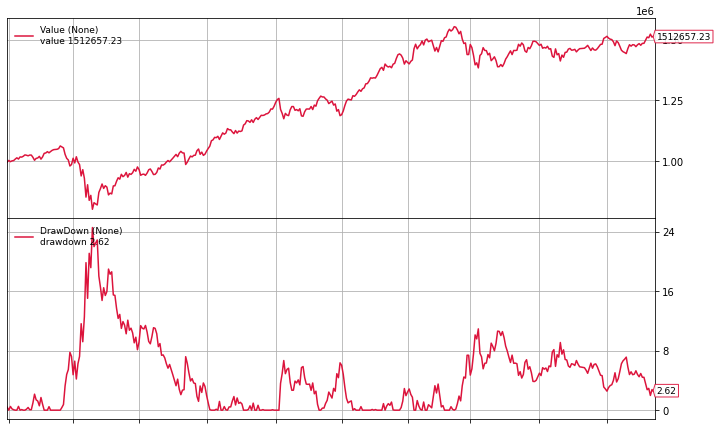

In [230]:
# Backtesting Mean Variance Strategy
assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [231]:
# Show Mean Variance Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 24.55%
CAGR: 7.63%
Sharpe: 0.532


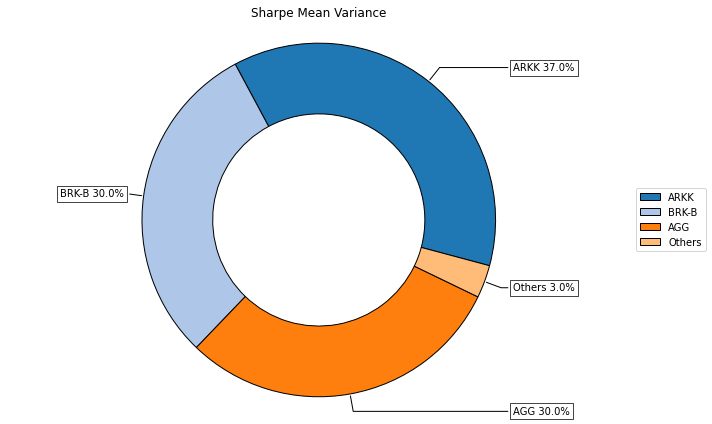

In [232]:
# Plotting the composition of the last MV portfolio
import riskfolio.PlotFunctions as plf

w = pd.DataFrame(models['MV'].iloc[-1,:])

ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

---
# Mean CVaR Strategy
---

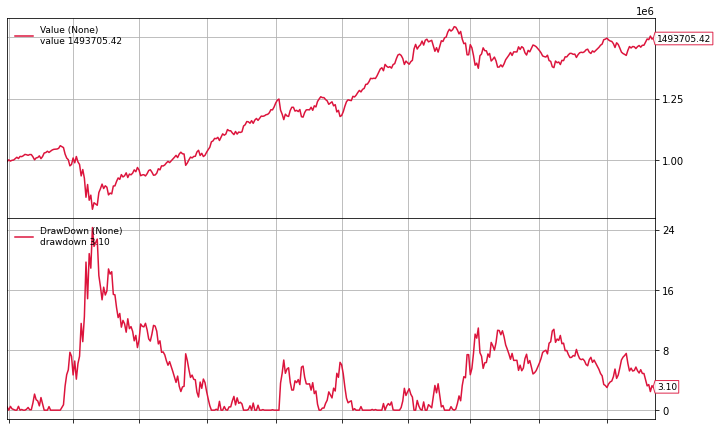

In [233]:
# Backtesting Mean CVaR Strategy
assets = returns.columns.tolist()
weights = models['CVaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [234]:
# Show CVaR Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 24.30%
CAGR: 7.39%
Sharpe: 0.527


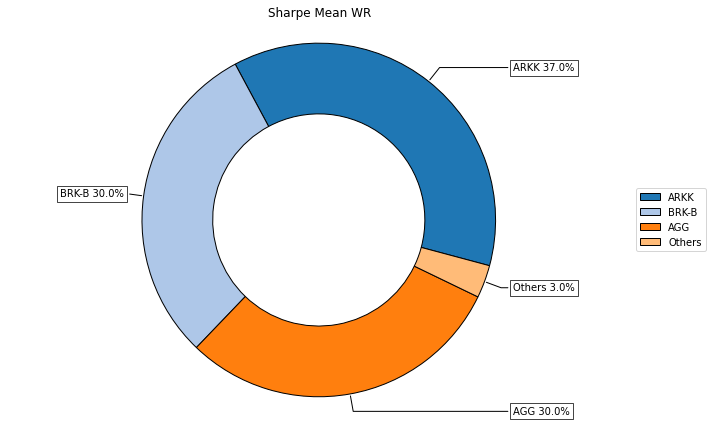

In [235]:
# Plotting the composition of the last WR portfolio
w = pd.DataFrame(models['CVaR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean WR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

---
# Mean Worst Realization Strategy
---

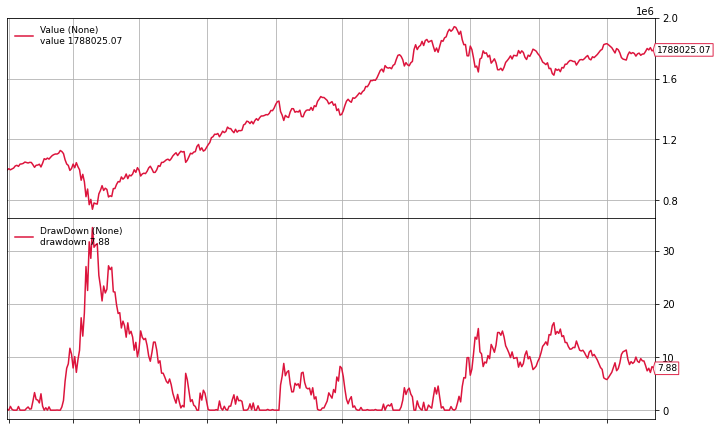

In [236]:
# Backtesting Mean Worst Realization Strategy
assets = returns.columns.tolist()
weights = models['WR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [237]:
# Show Worst Realization Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 34.34%
CAGR: 10.77%
Sharpe: 0.483


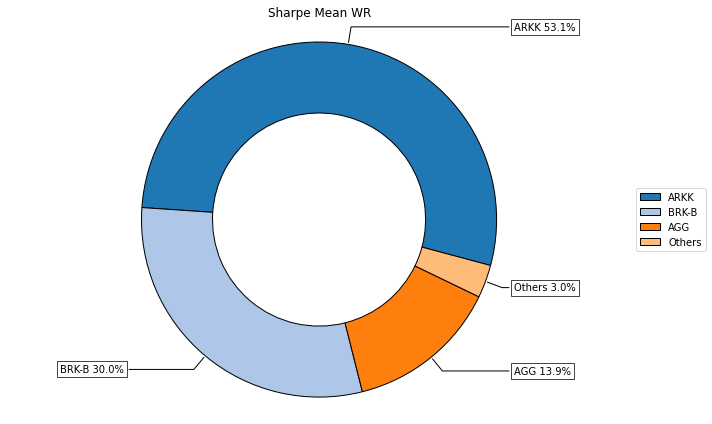

In [238]:
# Plotting the composition of the last WR portfolio
w = pd.DataFrame(models['WR'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='Sharpe Mean WR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)


---
# Mean CDaR Strategy
---

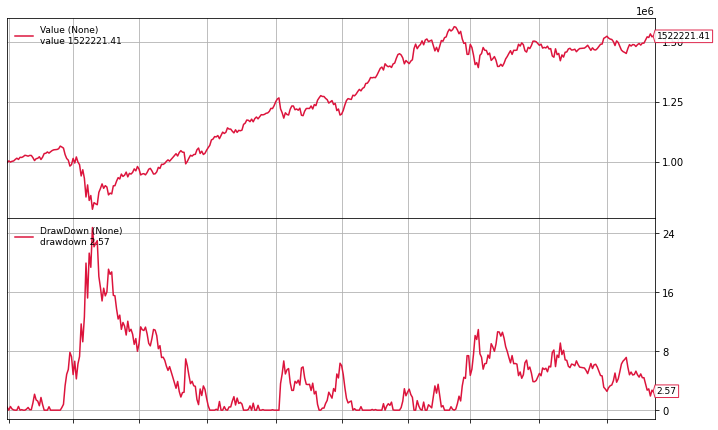

In [239]:
# Backtesting Mean CDaR Strategy
assets = returns.columns.tolist()
weights = models['CDaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [240]:
# Show CDaR Strategy Stats 
print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 24.76%
CAGR: 7.76%
Sharpe: 0.531


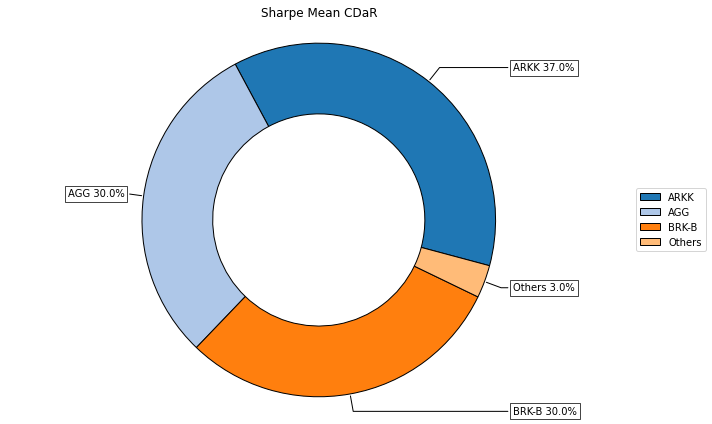

In [241]:
# Plotting the composition of the last CDaR portfolio
w = pd.DataFrame(models['CDaR'].iloc[-1,:])

ax = plf.plot_pie(w=w, title='Sharpe Mean CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)